In [14]:
# import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1: Data Loading and Initial Exploration

In [8]:
# loading the dataset
file_path = "titanic3.xls"
df = pd.read_excel(file_path)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Before preprocessing and feature engineering, we must understand the dataset to identify inconsistencies before modeling as well as revealing patterns/distributions helpful for preprocessing decisions.

1. Checking Dataset Structure 
Firstly, I began by checking some basic information such as the shape of the dataset as well as the column names, to check the number of rows we have and columns (features), and to gain a general overview of what data we have to analyze. 

2. Identifying Missing Values
Missing data can affect the model's accuracy, so it is very important to assess which features have missing values. After observation, I noticed: 
- age is missing for 263 passengers 
- fare is missing for 1 passengers 
- cabin is missing for 1014 passengers
- embarked is missing for 2 passengers 
- boat is missing for 823 passengers 
- body is missing for 1188 passengers 
- home.dest is missing for 564 passengers 
We can see that cabin, boat, and body have an extremely high number of missing values, which might make them not useful.
Home.dest also has lots of missing values, though fewer than the others.
Age, fare, and embarked have much fewer missing values, which means they could still be useful with appropriate handling.

3. Summary Statistics Observations
After checking the missing values, .describe() is used to view summary statistics about the dataset. Some key observations include:
Age:
- a minimum age of 0.17 years (babies) 
- a maximum age of 80 years. 
Fare:
- Some passengers paid $0, which could be an error or maybe a special case. 
Pclass:
- Most passengers were in 3rd class, which confirms a class imbalance.

In [9]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

# check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# summary statistics
df.describe()

Dataset Shape: (1309, 14)

Column Names:
 Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

Missing Values:
 pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Visualizing data helps in understanding missing values, identifying patterns based on features such as gender, class, and age, and spotting imbalances that might affect model predictions.

1. Heatmap of Missing Values
Although I quantitatively observed missing values  earlier, a heatmap provides a visual aid for recognizing missing data across the different columns and helps determine if a column is too incomplete to be useful. 
- Cabin, boat, and body have too many missing values, making them hard to work with.
- Age and embarked have less missing values, meaning they might still be useful for prediciton.

2. Survival by Gender
This visualization helps check whether gender impacted survival rates.
- The countplot shows that more men died compared to women (possibly due to the women and children first rule).
From this, we can infer gender is going to be an important feature for predicting survival.

3. Survival by Passenger Class
This allows us to check if ticket class could have affected chance of survival.
- 1st class passengers had higher survival rates
- 3rd class passengers had the highest death rate 
This suggets that the wealthier passengers had better access to lifeboats, and we can therefore infer that class is related to survival and that we should include it in our model.

4. Age Distribution of Survivors vs Non-survivors
This allows us to see if age could have affected survival rates.
- Children had higher survival rates (again, women and children first rule).
- Elderly passengers had lower survival rates, possibly due to physical limitations in evacuations.
- Adults (20-40) had more non-survivors than survivors, but survival was still present across the group. 
Since survival varies across different age ranges, categorizing passengers into age groups may improve model performance compared to using raw age values.

Summary of insights gathered:
- Columns with too many missing values may be dropped, while others imputed.
- Gender, class, and age are all likely important factors.
- Age could benefit from categorization into groups.

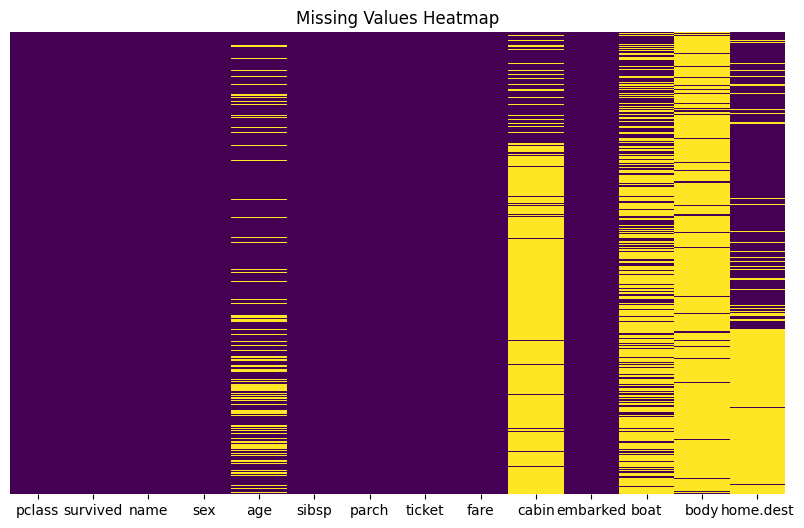

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

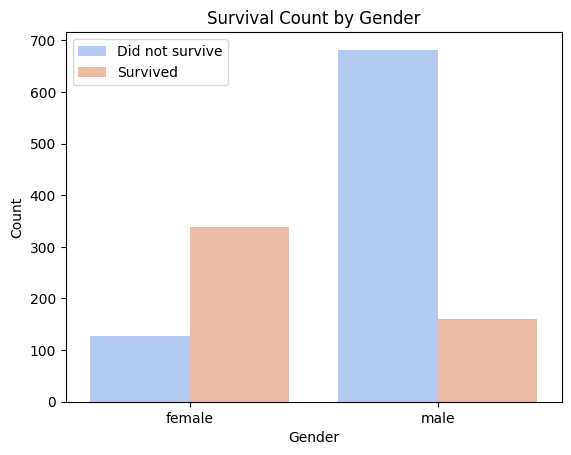

In [11]:
sns.countplot(data=df, x='sex', hue='survived', palette='coolwarm')
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(["Did not survive", "Survived"])
plt.show()

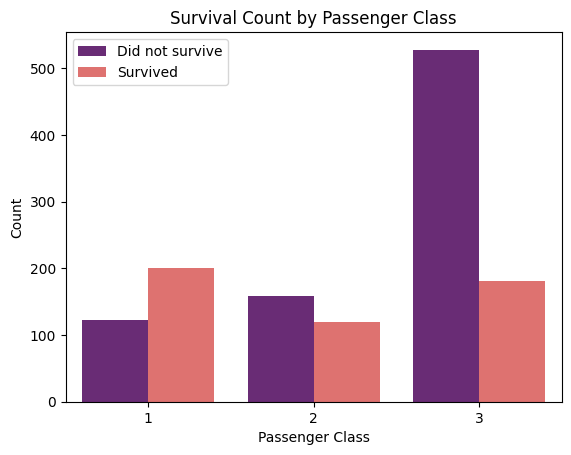

In [12]:
sns.countplot(data=df, x='pclass', hue='survived', palette='magma')
plt.title("Survival Count by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(["Did not survive", "Survived"])
plt.show()

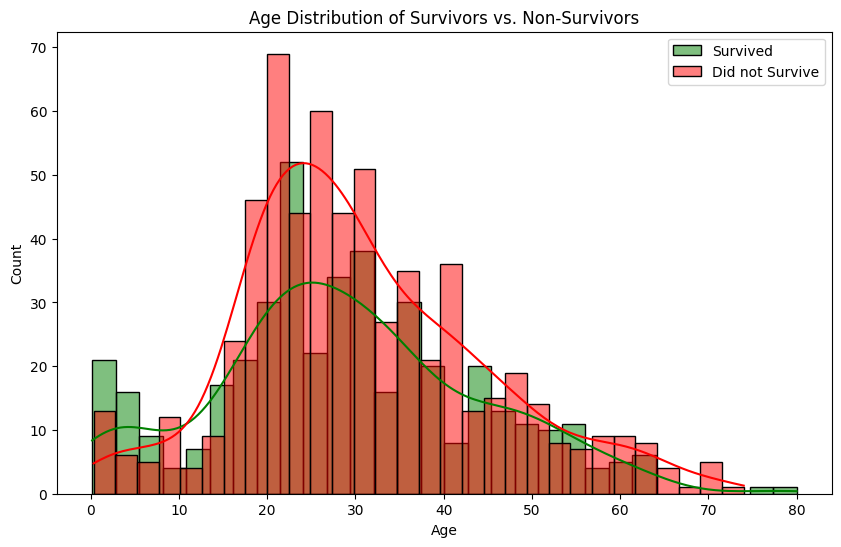

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['survived'] == 1]['age'], bins=30, kde=True, color="green", label="Survived")
sns.histplot(df[df['survived'] == 0]['age'], bins=30, kde=True, color="red", label="Did not Survive")
plt.legend()
plt.title("Age Distribution of Survivors vs. Non-Survivors")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Task 2: Data Splitting

Although data splitting is task 5 in the instructions, after careful review, I have decided to move task 5 to task 2 to prevent data leakage. There are two main reasons for my choice:

1. Imputting missing values before splitting means computed values (such as median) would be based on the entire dataset, which would include the test and validation sets. This allows data that the model will be tested/validated on later to influence training data, which would lead to overly good results.


2. If we scale features before splitting, the mean and standard deviation are computed from the entire dataset, which means that test data would influence how the training data is transformed, leading to data leakage. 

The dataset was divided into training (80%), validation (10%), and test (10%) sets. Stratification was used on survived, so that the percentage of survivors is consistent across all splits. Without stratification, there might be too many survivors randomly assigned to one set and too little to another, which would lead to unreliable model training.

1. First split (80% training, 20% others):
- The training set should be the largest portion, since it is used to train the model
- Random state is set to 42, for reproducibility

2. Second split (10% validation, 10% test):
- The validation set is used to tune hyperparameters and prevent overfitting.
- The test set allows for an unbiased evaluation of the model performance

The decision of 80 10 10 is based on a general rule of thumb, especially since the dataset is relatively large.

In [15]:
# defining the target variable
y = df["survived"]  # target column to predict
X = df.drop(columns=["survived"])  # features we use to make predictions

# first split: training (80%) and others (20%)
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# second split: validation (10%) and test (10%) from 'others'
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=42
)

# confirming the shape of the splits
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (1047, 13) (1047,)
Validation Set: (131, 13) (131,)
Test Set: (131, 13) (131,)


# Task 3: Managing Missing Values